Classifying White Blood Cells
HU Extension | CSCI E89 Deep Learning | Final Project

Jonak, Paul

Submitted May 8, 2018

=================================================

About the code contained within:

This portion of code is intended to usage of the final model to predict the class of a white blood cell.

=================================================

Section 0: Set Environment Parameters

In [24]:
# We will load all the same packages as with the data prep and model building code

# load system packages
import copy
import os
import shutil
import sys

# Load third-party packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
import PIL
import cv2


import keras
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6731896703400051101
]


In [25]:
# Identify where data will be stored
#   root dir
fpRoot = 'C:/Users/Paul/Documents/Courses/2018_1_HarExt_CSCI_E89__DeepLearning'
if not os.path.exists(fpRoot):
    fpRoot = 'C:/Users/Paul Jonak/Documents/Courses/2018_1_HarExt_CSCI_E89__DeepLearning'

#   dir for source images
fpSrc = os.path.join(fpRoot, 'data', 'FinalProject', 'src')
#   dir for prepared images
fpPrep = os.path.join(fpRoot, 'data', 'FinalProject', 'prep')
#   dir for dataset, small exploratory set
fpDatSmall = os.path.join(fpRoot, 'data', 'FinalProject', 'dat_small')
#   dir for dataset, medium set
fpDatMedium = os.path.join(fpRoot, 'data', 'FinalProject', 'dat_medium')
#   dir for dataset, full final set
fpDatFull = os.path.join(fpRoot, 'data', 'FinalProject', 'dat_full')

In [26]:
# Identify where models are stored
dirSaveModel = os.path.join(fpRoot, 'code', 'final_prj')

# Identify where images are stored
fpDir = os.path.join(fpDatSmall, 'downsample', 'test')

=================================================

Section 1: Select & Load Model

In [27]:
# Select model to use
fnModel = 'full_l2reg_0.01.h5'

# Load model
#   Get filepath
fpModel = os.path.join(dirSaveModel, fnModel)
#   Load
model = keras.models.load_model(fpModel)
#   Report model structure
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1410 (Conv2D)         (None, 118, 158, 8)       224       
_________________________________________________________________
max_pooling2d_978 (MaxPoolin (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_1411 (Conv2D)         (None, 57, 77, 16)        1168      
_________________________________________________________________
max_pooling2d_979 (MaxPoolin (None, 28, 38, 16)        0         
_________________________________________________________________
conv2d_1412 (Conv2D)         (None, 26, 36, 16)        2320      
_________________________________________________________________
max_pooling2d_980 (MaxPoolin (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_1413 (Conv2D)         (None, 11, 16, 16)        2320      
__________

=================================================

Section 2: Prepare for Making Predictions

In [28]:
# Prepare ImageDataGenerator
#   Important: shuffle must be set to FALSE
#   uint8 images -> max pixel value = 255
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
            fpDir,
            target_size=(120, 160),
            batch_size=4*len(os.listdir(os.path.join(fpDir, os.listdir(fpDir)[0]))),
            shuffle=False,
            classes=None, # will be inferred from subdirectory names
            class_mode='categorical')

# Get listing of the classes
#   Predictions will give us an index. We need to convert the index to a class.
dictClass = {test_generator.class_indices[sKey]: sKey for sKey in test_generator.class_indices.keys()}

# Get all images and their predictions
x_batch, y_batch = next(test_generator)
# Get true labels
y_true = test_generator.classes

Found 120 images belonging to 4 classes.


=================================================

Section 3: Make Predictions

In [29]:
# Get predictions for all images in the designated folder
y_pred = model.predict_generator(test_generator)
print("Number of predictions: " + str(len(y_pred)))
print("Sample model output for image 1 (idx=0)")
print(y_pred[0])

Number of predictions: 120
Sample model output for image 1 (idx=0)
[1.0000000e+00 6.2410428e-13 1.0888647e-24 8.9372648e-11]


=================================================

Section 4: Inspect Predictions

In [30]:
def inspect_prediction(test_generator, x_batch, y_pred, y_true, idx=None):
    if idx is None:
        # Get random index
        idx = np.random.choice(x_batch.shape[0])
        
    # Get filename
    fn = test_generator.filenames[idx]
    
    # Get associated class and prediction
    sClass_true = dictClass[y_true[idx]]
    sClass_pred = dictClass[np.argmax(y_pred[idx])]
    
    I_match = sClass_true==sClass_pred
    
    # Plot associated image
    plt.imshow(x_batch[idx, :, :, :].transpose(1,0,2)[:,:,::-1])
    plt.show()

    # Print results
    print(fn)
    print("Class = " + sClass_true + "\nPredicted = " + sClass_pred + "\nMatch = " + str(I_match))
    
    return I_match, idx, fn

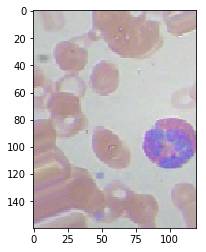

EOSINOPHIL\EOSINOPHIL.1241.jpg
Class = EOSINOPHIL
Predicted = EOSINOPHIL
Match = True




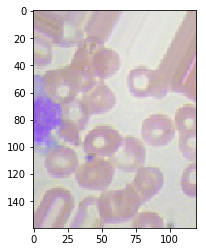

MONOCYTE\MONOCYTE.1266.jpg
Class = MONOCYTE
Predicted = MONOCYTE
Match = True




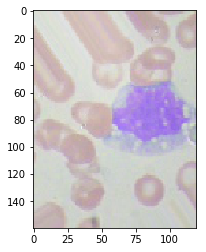

MONOCYTE\MONOCYTE.1256.jpg
Class = MONOCYTE
Predicted = MONOCYTE
Match = True




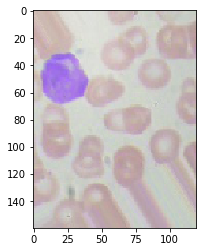

LYMPHOCYTE\LYMPHOCYTE.1256.jpg
Class = LYMPHOCYTE
Predicted = LYMPHOCYTE
Match = True




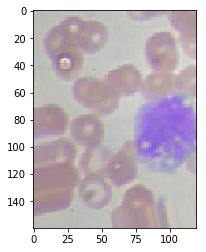

MONOCYTE\MONOCYTE.1254.jpg
Class = MONOCYTE
Predicted = MONOCYTE
Match = True



   I_match                        filename  idx_img
0      1.0  EOSINOPHIL\EOSINOPHIL.1241.jpg      0.0
1      1.0      MONOCYTE\MONOCYTE.1266.jpg     87.0
2      1.0      MONOCYTE\MONOCYTE.1256.jpg     76.0
3      1.0  LYMPHOCYTE\LYMPHOCYTE.1256.jpg     46.0
4      1.0      MONOCYTE\MONOCYTE.1254.jpg     74.0


In [32]:
# Define how many predictions to run
nSample = 5

# Prepare holder for results
dfRes = pandas.DataFrame()
# Make predictions
for iSample in range(nSample):
    print("\n")
    # Get prediction
    I_match, idx, fn = inspect_prediction(test_generator=test_generator,
                                          x_batch=x_batch,
                                          y_pred=y_pred,
                                          y_true=y_true)
    # Save prediction
    dfRes = dfRes.append({"I_match": I_match,
                          "idx_img": idx,
                          "filename": fn}, ignore_index=True)

# Show results
print("\n\n")
print(dfRes)